In [3]:
# Import dependencies
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bisect import bisect_left, bisect_right
import os
import seaborn as sns
import typing
from datetime import date, timedelta, datetime
from utils import convert_from_json_to_df

data source: https://derivative.credit-suisse.com/ch/ch/en/detail/autocallable-brc-lonza-sika-8-00-p-a/CH1253871557/125387155

[*********************100%%**********************]  2 of 2 completed


<Axes: xlabel='Date'>

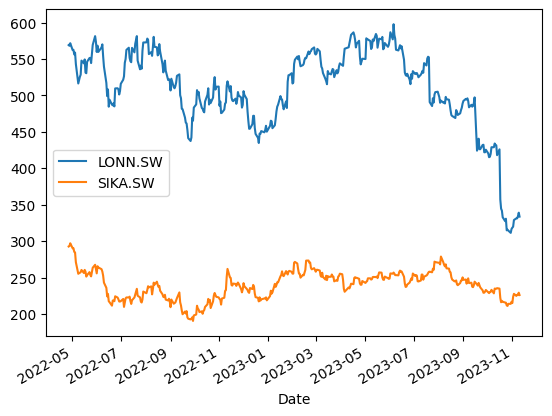

In [56]:
# Define the ticker list
import yfinance as yf
tickers_list = ['SIKA.SW', 'LONN.SW']

# Fetch the data
data = yf.download(tickers_list,'2022-04-27')['Adj Close']
data.plot()

In [57]:
data

,LONN.SW,SIKA.SW
Date,,
2022-04-27,569.189392,292.776306
2022-04-28,568.200867,293.368774
2022-04-29,571.759583,297.219788
2022-05-02,562.269714,290.307678
2022-05-03,562.665222,290.406433
...,...,...
2023-11-06,331.399994,225.000000
2023-11-07,331.399994,226.399994
2023-11-08,334.399994,226.500000


In [58]:
barriers = [329.76, 144.24]

In [59]:
print(data[data['LONN.SW'] <= barriers[0]]['LONN.SW'])
print(data[data['SIKA.SW'] <= barriers[1]]['SIKA.SW'])

Date
2023-10-23    327.600006
2023-10-25    315.000000
2023-10-26    315.899994
2023-10-27    314.600006
2023-10-30    311.500000
2023-10-31    316.799988
2023-11-01    318.600006
2023-11-02    320.000000
2023-11-03    329.100006
Name: LONN.SW, dtype: float64
Series([], Name: SIKA.SW, dtype: float64)


In [62]:
from model import SingleAssetGBM
params = {
    'name': 'LONN.SW',
    'maturity_date': '2024-08-05',
    'simulations': 1000,
    'window_size': 365,
    'prediction_range': ('2023-08-09', '2023-11-09'),
    'interest_rate_model': None, 
    'volatiliy_model': None,
    'variance_reduction': None,
}

current_date = '2023-08-09'
lonn = SingleAssetGBM(params)
path = lonn.fit(current_date, data['LONN.SW']).generate_paths()
path.shape

ImportError: cannot import name 'SingleAssetGBM' from 'model' (/Users/maffinnn/Desktop/mh4518/code/sy/model.py)

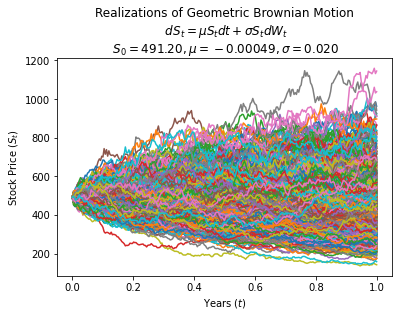

In [ ]:
tt = np.full(shape=path.T.shape, fill_value=np.linspace(0,1,259)).T
plt.plot(tt, path)
plt.xlabel("Years $(t)$")
plt.ylabel("Stock Price $(S_t)$")
plt.title(
    f"Realizations of Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {lonn.S0:.2f}, \mu = {lonn.mu:.5f}, \sigma = {lonn.sigma:.3f}$"
)
plt.show()

In [ ]:
denomination = 1000
product_price = convert_from_json_to_df('data/product/price.json')
product_price = product_price.set_index('date')
product_price['price'] = product_price['value'] / 100.0 * denomination

In [ ]:
product_price

,value,price
date,,
2023-10-30,60.75,607.5
2023-10-27,61.30,613.0
2023-10-26,61.57,615.7
2023-10-25,61.54,615.4
2023-10-24,64.23,642.3
...,...,...
2023-05-05,98.82,988.2
2023-05-04,98.51,985.1
2023-05-03,98.09,980.9


### Interest rate model
- Vasicek: $dr_t = a (b - r_t) dt + \sigma r_t dW_t$
- CIR: $dr_t = a (b - r_t) dt + \sigma \sqrt{r_t} dW_t$ => not suitable in our case because switzerland's interest rate is negative in 2022.
- data from: https://www.investing.com/rates-bonds/switzerland-30-year-bond-yield-historical-data

In [2]:
from utils import get_period
path = '../../data/bond'

bond_yield = None
for file in os.listdir(path):
   df = pd.read_csv(os.path.join(path, file))[['Date','Price']]
   df.rename(columns={'Price':file.split(' ')[1]}, inplace=True)
   df['Date'] = pd.to_datetime(df['Date'],format='%m/%d/%Y')
   df = df.set_index('Date').iloc[::-1]
   if bond_yield is None:
      bond_yield = df
   else:
      bond_yield = pd.concat([bond_yield, df], axis=1)
bond_yield = bond_yield.interpolate()

In [3]:
bond_yield = bond_yield.reindex(sorted(bond_yield.columns, key=lambda x: get_period(x)), axis=1)
bond_yield

,1-Week,1-Month,2-Month,3-Month,6-Month,1-Year,2-Year
Date,,,,,,,
2022-01-01,-1.00,-0.80,-0.78,-0.95,-0.90,-0.80,NaN
2022-01-02,-1.00,-0.77,-0.76,-0.90,-0.85,-0.80,NaN
2022-01-03,-0.88,-0.84,-0.87,-0.86,-0.85,-0.80,-0.700
2022-01-04,-0.90,-0.86,-0.74,-0.86,-0.85,-0.73,-0.729
2022-01-05,-0.94,-0.87,-0.80,-0.87,-0.85,-0.73,-0.715
...,...,...,...,...,...,...,...
2023-11-05,1.60,1.60,1.64,1.62,1.60,1.70,1.330
2023-11-06,1.58,1.59,1.64,1.61,1.65,1.67,1.326
2023-11-07,1.58,1.59,1.63,1.61,1.65,1.67,1.338


In [4]:
from interest_rate import get_period
bond_price = pd.DataFrame(index=bond_yield.index)
for col in bond_yield.columns:
    bond_price[col] = bond_yield[col].apply(lambda x: np.exp(-x/100*get_period(col)))
bond_price

,1-Week,1-Month,2-Month,3-Month,6-Month,1-Year,2-Year
Date,,,,,,,
2022-01-01,1.000192,1.000667,1.001301,1.002378,1.004510,1.008032,NaN
2022-01-02,1.000192,1.000642,1.001267,1.002253,1.004259,1.008032,NaN
2022-01-03,1.000169,1.000700,1.001451,1.002152,1.004259,1.008032,1.014098
2022-01-04,1.000173,1.000717,1.001234,1.002152,1.004259,1.007327,1.014687
2022-01-05,1.000181,1.000725,1.001334,1.002177,1.004259,1.007327,1.014403
...,...,...,...,...,...,...,...
2023-11-05,0.999692,0.998668,0.997270,0.995958,0.992032,0.983144,0.973751
2023-11-06,0.999696,0.998676,0.997270,0.995983,0.991784,0.983439,0.973829
2023-11-07,0.999696,0.998676,0.997287,0.995983,0.991784,0.983439,0.973595


356
0.9813048364213841


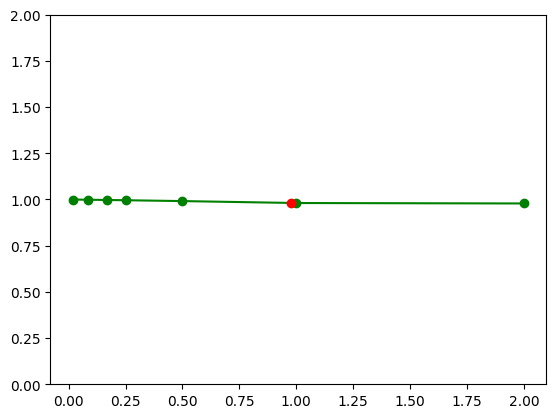

In [5]:
current_date = '2023-08-09'
final_fixing_date = '2024-07-30'
format = '%Y-%m-%d'
tdelta = (datetime.strptime(final_fixing_date, format) - datetime.strptime(current_date, format)).days
print(tdelta)

X = [get_period(col) for col in bond_price.columns]
Y = bond_price.loc[current_date].to_list()
interpolated_y = np.interp(tdelta/365,X,Y)
print(interpolated_y)
plt.ylim((0,2))
plt.plot(X, Y, "og-", tdelta/365, interpolated_y, "or");

In [5]:
from interest_rate import populate_bond_table
bond_table = populate_bond_table(bond_price)
bond_table

,price
Date,
2022-01-01,NaN
2022-01-02,NaN
2022-01-03,1.014098
2022-01-04,1.014687
2022-01-05,1.014403
...,...
2023-11-05,0.987868
2023-11-06,0.98792
2023-11-07,0.987966


[]

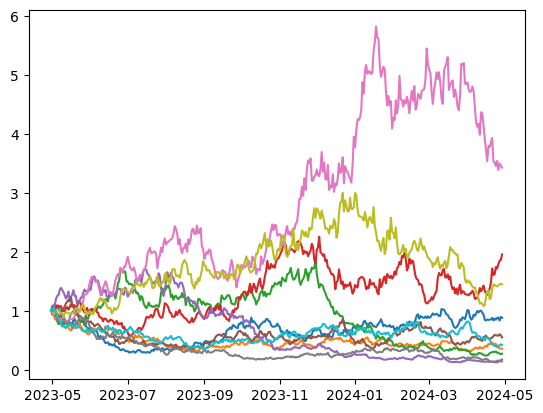

In [4]:
from model import genGBM, future_payouts, rnv
#viz of price paths
N = 10
pathArr = []
plt.figure()
for i in range(N):
    pathArr.append(genGBM(1, date.fromisoformat('2023-04-30'), 0.1, 1, 1/365, 365))
    plt.plot(pathArr[i]['date'], pathArr[i]['price'])
plt.plot()

In [4]:
t_0 = date.fromisoformat('2023-04-27')
today = date.fromisoformat('2023-08-01')
final_fixing_date = date.fromisoformat('2024-07-30')
r = 0.05
payoffs = []
df_end1_n = []
df_end2_n = []
N = 10
for i in range(N):
    df_path1 = genGBM(1, t_0, 0.04, 0.1, 1/365, 465)
    df_path2 = genGBM(1, t_0, 0.04, 0.1, 1/365, 465)
    df_end1_n.append(df_path1['price'].to_numpy()[-1])
    df_end2_n.append(df_path2['price'].to_numpy()[-1])
    df_payouts = future_payouts(df_path1, df_path2, False)
    v = rnv(df_payouts, today, r)
    payoffs.append(v)
print(payoffs)
print(df_end1_n)
print(df_end2_n)

[1033.7864463643152, 1040.96307773131, 1048.0508022778185, 1048.0508022778185, 1026.5197929497006, 1048.0508022778185, 1048.0508022778185, 1026.5197929497006, 1033.7864463643152, 1026.5197929497006]
[1.049334288823453, 1.22605367014795, 1.0480382599161193, 0.9616621163788625, 1.0190879919566191, 1.0988051334118205, 0.914722782165114, 1.0949919625413969, 1.0959543125059152, 1.1425986373799595]
[0.969242744663685, 1.1209252082440102, 0.9308810761277857, 1.026181695369803, 1.1878764285443473, 0.9775638951568071, 1.0873264687977329, 1.05751346117867, 1.059525202707727, 1.1439115059411524]


In [5]:
s_01  = 1
s_02 = 1.2
mu1 = s_01 * np.exp(r*(final_fixing_date - today).days/365)
mu2 = s_02 * np.exp(r*(final_fixing_date - today).days/365)
print(mu1, mu2)

1.0511270965000248 1.2613525158000296


In [6]:
from variance_reduction import apply_control_variates
payoffs_cv = apply_control_variates(df_end1_n, df_end2_n, mu1, mu2, payoffs)

In [92]:
payoffs_cv

array([1029.72379916, 1022.30187824, 1028.90338924, 1019.76957518,
       1014.84824125])

In [3]:
from interest_rate import VasicekModel
params = {
    'speed of reversion': 0,
    'long term mean level': 0.107659718380514,
    'sigma': 0.106212663278328,
    'maturity_date': '2024-07-30',
}
Vasicek = VasicekModel(bond3M, params)
path = Vasicek.generate_path('2023-08-09')
path

,Rate
2023-08-09,1.653833
2023-08-10,1.646162
2023-08-11,1.647886
2023-08-12,1.642562
2023-08-13,1.641726
...,...
2024-07-26,1.708214
2024-07-27,1.707965
2024-07-28,1.701852
2024-07-29,1.708852


In [12]:
t_0 = date.fromisoformat('2023-04-27')
today = date.fromisoformat('2023-08-01')
df_path1 = genGBM(1, t_0, 0.04, 0.1, 1/365, 465)
df_path2 = genGBM(1, t_0, 0.04, 0.1, 1/365, 465)

In [13]:
df_path1 = df_path1.set_index('date')
df_path1

,price
date,
2023-04-27,1.000000
2023-04-28,1.000249
2023-04-29,0.998482
2023-04-30,0.997326
2023-05-01,0.996258
...,...
2024-07-31,1.138650
2024-08-01,1.128094
2024-08-02,1.128722


In [21]:
corrected_path = pd.DataFrame(index=df_path1.index, columns=df_path1.columns)
col = df_path1.columns[0]
corrected_path.iloc[0] = df_path1.iloc[0]
for j in range(1, len(df_path1.index)):
    corrected_path.iloc[j][col] = corrected_path.iloc[j-1][col] * df_path1.iloc[j][col]/df_path1.iloc[j-1][col]
corrected_path

,price
date,
2023-04-27,1.0
2023-04-28,1.000249
2023-04-29,0.998482
2023-04-30,0.997326
2023-05-01,0.996258
...,...
2024-07-31,1.13865
2024-08-01,1.128094
2024-08-02,1.128722
